In [ ]:
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.ops.init_ops import VarianceScaling

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [0]:
env = gym.make("Breakout-v0")

In [0]:
input_size = 80 * 80
n_actions = env.action_space.n # number of actions

In [0]:
# preprocess function
def preprocess(image, first=False):
    """ prepro 210x160x3 uint8 frame into 6400 (or 80x80) nD float array """
    image = image[35:195] # crop
    image = image[::2,::2,0] # downsample by factor of 2
    image[image == 144] = 0 # erase background (background type 1)
    image[image == 109] = 0 # erase background (background type 2)
    image[image != 0] = 1 # everything else just set to 1
    return np.reshape(image.astype(np.float).ravel(), [80, 80, 1])

In [0]:
class DQN_Agent:

    def __init__(self, 
                 n_actions, 
                 n_features, 
                 learning_rate=0.01,
                 reward_decay=0.95,
                 e_greedy=0.95,
                 update_params_step=300,
                 buffer_size=500,
                 batch_size=32,
                 save_dir = './Breakout-v0_save_dqn/'):
        
        # set up all parameters
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = reward_decay
        self.replace_target_iter = update_params_step
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.epsilon = e_greedy
        self.save_dir = save_dir

        # total learning step
        self.learn_step_counter = 0

        # initialize zero memory
        self.memory = np.zeros((self.buffer_size, n_features * 2 + 2))

        # build two networks: target_net, online_net
        self._build_net()
        t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='target_q_net')
        e_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='eval_q_net')

        with tf.variable_scope('update_all_parameters', reuse=tf.AUTO_REUSE):
            self.target_replace_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]

        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        self.max_q = []

    def _build_net(self):
        """Builds online net and target net"""
        # initialize state, next state, reward, action
        n_features_tensor = [None, 80, 80, 1]
        self.s = tf.placeholder(tf.float32, n_features_tensor, name='s')  
        self.s_ = tf.placeholder(tf.float32, n_features_tensor, name='s_')  
        self.r = tf.placeholder(tf.float32, [None, ], name='r')  
        self.a = tf.placeholder(tf.int32, [None, ], name='a')  

        # initialize weight     
        def lecun_normal(seed=None):
          return VarianceScaling(scale=1., mode='fan_in', distribution='truncated_normal', seed=seed)
        def lecun_uniform(seed=None):
          return VarianceScaling(scale=1., mode='fan_in', distribution='uniform', seed=seed)
        w_initializer = lecun_normal()
        b_initializer = tf.zeros_initializer()

        # build online net 
        with tf.variable_scope('online_net', reuse=tf.AUTO_REUSE):
            conv1 = tf.layers.conv2d(inputs=self.s,
                                     filters=32,
                                     kernel_size=[8, 8],
                                     strides=(4, 4),
                                     padding="same",
                                     activation=tf.nn.relu6,
                                     kernel_initializer=w_initializer)
            conv2 = tf.layers.conv2d(inputs=conv1,
                                     filters=64,
                                     kernel_size=[4, 4],
                                     strides=(2, 2),
                                     padding="same",
                                     activation=tf.nn.relu6,
                                     kernel_initializer=w_initializer)
            conv3 = tf.layers.conv2d(inputs=conv2,
                                     filters=64,
                                     kernel_size=[3, 3],
                                     strides=(1, 1),
                                     padding="same",
                                     activation=tf.nn.relu6,
                                     kernel_initializer=w_initializer)
            flat = tf.contrib.layers.flatten(conv3)
            dense1 = tf.layers.dense(
                            inputs=flat,
                            units=512, 
                            activation=tf.nn.relu,
                            kernel_initializer=w_initializer,
                            bias_initializer=b_initializer)
            self.q_eval = tf.layers.dense(dense1, self.n_actions, kernel_initializer=w_initializer,
                                          bias_initializer=b_initializer, name='online')

        # build target_net
        with tf.variable_scope('target_net', reuse=tf.AUTO_REUSE):
            conv1 = tf.layers.conv2d(inputs=self.s_,
                                     filters=32,
                                     kernel_size=[8, 8],
                                     strides=(4, 4),
                                     padding="same",
                                     activation=tf.nn.relu6,
                                     kernel_initializer=w_initializer)          
            conv2 = tf.layers.conv2d(inputs=conv1,
                                     filters=64,
                                     kernel_size=[4, 4],
                                     strides=(2, 2),
                                     padding="same",
                                     activation=tf.nn.relu6,
                                     kernel_initializer=w_initializer)
            conv3 = tf.layers.conv2d(inputs=conv2,
                                     filters=64,
                                     kernel_size=[3, 3],
                                     strides=(1, 1),
                                     padding="same",
                                     activation=tf.nn.relu6,
                                     kernel_initializer=w_initializer)
            flat = tf.contrib.layers.flatten(conv3)
            dense1 = tf.layers.dense(
                            inputs=flat,
                            units=512, 
                            activation=tf.nn.relu,
                            kernel_initializer=w_initializer,
                            bias_initializer=b_initializer)           
            self.q_next = tf.layers.dense(dense1, self.n_actions, kernel_initializer=w_initializer,
                                          bias_initializer=b_initializer, name='target')

        # target Q value
        with tf.variable_scope('q_target', reuse=tf.AUTO_REUSE):
            q_target = self.r + self.gamma * tf.reduce_max(self.q_next, axis=1, name='Qmax_s_')    
            self.q_target = tf.stop_gradient(q_target)
        # online Q value
        with tf.variable_scope('q_online', reuse=tf.AUTO_REUSE):
            a_indices = tf.stack([tf.range(tf.shape(self.a)[0], dtype=tf.int32), self.a], axis=1)
            self.q_eval_wrt_a = tf.gather_nd(params=self.q_eval, indices=a_indices)   
        # loss function
        with tf.variable_scope('loss', reuse=tf.AUTO_REUSE):
            self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_eval_wrt_a, name='TD_error'))
        # minimize the difference
        with tf.variable_scope('train', reuse=tf.AUTO_REUSE):
            self._train_op = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss)

    def store_transition(self, s, a, r, s_):
        """Store replay memory"""
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0
        transition = np.hstack((s.ravel(), [a, r], s_.ravel()))
        # replace the old memory with new memory
        index = self.memory_counter % self.buffer_size
        self.memory[index, :] = transition
        self.memory_counter += 1

    def choose_action(self, state):
        """Predict action"""
        state = state[np.newaxis, :]
        if np.random.uniform() < self.epsilon:
            # forward feed the state and get q value for every actions
            actions_value = self.sess.run(self.q_eval, feed_dict={self.s: state})
            action = np.argmax(actions_value)
        else:
            action = np.random.randint(0, self.n_actions)
        return action

    def learn(self):
        """Update value parameters using given batch and train the network"""    
        # check to replace target parameters
        if self.learn_step_counter % self.replace_target_iter == 0:
            self.sess.run(self.target_replace_op)

        # sample batch memory when memory is full
        if self.memory_counter > self.buffer_size:
            sample_index = np.random.choice(self.buffer_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
        batch_memory = self.memory[sample_index, :]

        # train the nextwork
        n_features_tensor = [self.batch_size, 80, 80, 1]
        _, loss, q_n = self.sess.run(
            [self._train_op, self.loss, self.q_eval_wrt_a],
            feed_dict={
                self.s: np.reshape(batch_memory[:, :self.n_features], newshape = n_features_tensor),
                self.a: batch_memory[:, self.n_features],
                self.r: batch_memory[:, self.n_features + 1],
                self.s_: np.reshape(batch_memory[:, -self.n_features:], newshape = n_features_tensor),
            })

        # store the loss & q-value for inspection
        self.max_q.append(np.max(q_n))

        # tracking training steps (for parameters update & plotting)
        self.learn_step_counter += 1
    
    def plot_max_q(self):
        """Plot (average) maximum of the Q function versus iteration"""
        self.mean_max_q = [x[0]/x[1] for x in list(zip(np.cumsum(self.max_q), range(1,len(self.max_q)+1)))]
        plt.plot(np.arange(len(self.mean_max_q)), self.mean_max_q)
        plt.ylabel('(average) maximum of the Q function')
        plt.xlabel('iteration')
        plt.show()  
        
    def save_model(self):
        self.ckpts_path = self.save_dir + "dqn.ckpt"
        self.saver = tf.train.Saver()
        self.saver.save(self.sess, self.ckpts_path)

In [0]:
def train_DQN(episodes):
    """Train dqn network"""

    # keep track of steps for learning resets
    step = 0

    for episode in range(episodes):

        # initial state
        state = env.reset()

        while True:
            
            # choose action based on state
            action = dqn.choose_action(preprocess(state))

            # take action and get next state and reward
            state_, reward, done, info = env.step(action)

            # save observed states to memory
            dqn.store_transition(preprocess(state), action, reward, preprocess(state_))
            
            # only learn when there are enough episodes
            if (step > 1000) and (step % 10 == 0):
                dqn.learn()

            # next state as the current
            state = state_

            # break at end of an episode
            if done:
                if episode % 1000 == 0:
                    print('Finsihed episode {}'.format(str(episode)))
                break
            step += 1

    # end of game
    print('Game Over')
    env.close()

In [0]:
def play_game(episodes):
    """Play game based on trained dqn network"""
    
    saver = tf.train.Saver()
    saver.restore(dqn.sess, dqn.ckpts_path)

    # keep track of steps for learning resets
    step = 0
    
    rewards = []

    for episode in range(episodes):

        total_reward = 0
        
        # initial state
        state = env.reset()

        while True:
            
            # choose action based on state
            action = dqn.choose_action(preprocess(state))

            # take action and get next state and reward
            state_, reward, done, info = env.step(action)
            
            # Increment reward
            total_reward += reward

            # next state as the current
            state = state_

            # break at end of an episode
            if done:
                rewards.append(total_reward)
                break
            step += 1

    # end of game
    print('Game Over')
    env.close()
    
    """Visualize total rewards in a graph."""
    plt.plot(np.arange(len(rewards)), rewards)
    plt.ylabel('Total Reward')
    plt.xlabel('Episode')
    plt.show()

Finsihed episode 0
Finsihed episode 1000
Finsihed episode 2000
Finsihed episode 3000
Finsihed episode 4000
Finsihed episode 5000
Finsihed episode 6000
Finsihed episode 7000
Finsihed episode 8000
Finsihed episode 9000
Game Over


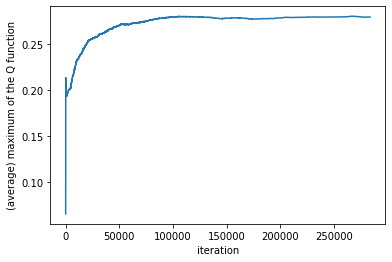

INFO:tensorflow:Restoring parameters from ./Breakout-v0_save_dqn/dqn.ckpt
Game Over


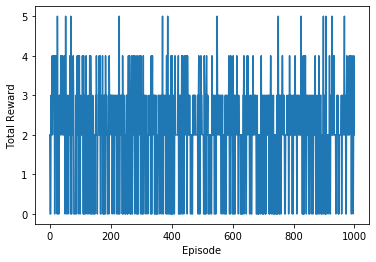

In [10]:
dqn = DQN_Agent(n_actions,
                input_size,
                learning_rate=0.005,
                reward_decay=0.95,
                e_greedy=0.9,
                update_params_step=200,
                buffer_size=2000)
    
train_DQN(episodes=10000)
    
dqn.plot_max_q()
dqn.save_model()
    
play_game(episodes=1000)